In [98]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import netCDF4
import numpy as np
import os
from datetime import datetime, date
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

In [102]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
Station_list = ['POLESOUT', 'KISSR0.0', 'LZ2', 'FEBIN', 'MBOXSOU', 'MH24000', 
                'FEBOUT', 'L005', 'L008', 'LZ40', 'L004', 'S308C', 'POLE3S', 
                'RITTAE2', 'L007', 'L006', 'PELBAY3', 'LZ30']

In [3]:
wavelength_array = [400, 412, 442, 490, 510, 560, 620, 665, 674, 681, 709, 754, 865, 940, 1012]

In [4]:
coordinate = pd.read_csv("coordinate.csv")
coordinate["Lat2"] = list(map(lambda lat: int(str(lat)[:2])+ int(str(lat)[2:4])/60 + float(str(lat)[4:])/3600,
                             coordinate["Latitude"]))
coordinate["Lon2"] = list(map(lambda lon: -(int(str(lon)[:2])+ int(str(lon)[2:4])/60 + float(str(lon)[4:])/3600),
                             coordinate["Longtitude"]))
coordinate[["Site Name", "Lat2", "Lon2"]]

,Site Name,Lat2,Lon2
0,POLESOUT,27.038198,-80.918541
1,KISSR0.0,27.141301,-80.846000
2,LZ2,27.189756,-80.828040
3,S133,27.206467,-80.801019
4,S135,27.086633,-80.661156
5,FEBIN,26.959360,-81.069347
6,MBOXSOU,26.921446,-81.059901
7,MH24000,26.877455,-81.018807
8,FEBOUT,26.971805,-81.005937
9,L005,26.956730,-80.972385


In [5]:
all_sentinel_files = []
folder = "/Users/quachhungvietnam/Desktop/Capstone/Sentinel_3_Data/S3_LO/"
files = os.listdir(folder)
for file in files:
    if "S3B" in file:
        path = f"{folder}{file}"
        data = netCDF4.Dataset(path)
        lon_array = np.array(data.variables["lon"])[0]
        lat_array = np.sort([x[0] for x in np.array(data.variables["lat"])])
        date = file[16:24]
        hour = file[25:31]
        all_sentinel_files.append([date,data,lon_array,lat_array])
        data.close()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


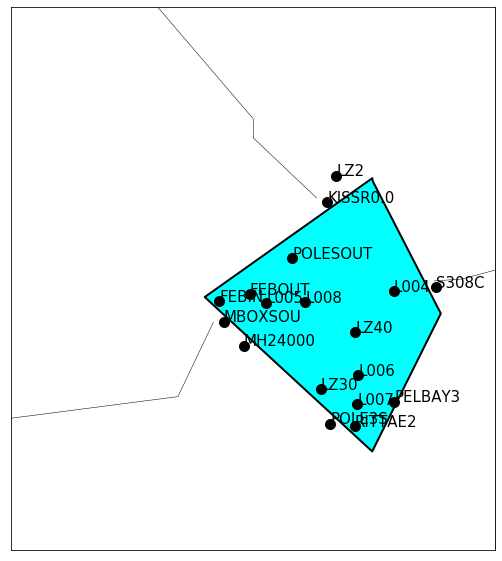

In [6]:
plt.figure(figsize=(10,10))
lat = 27
lon = -81
inclat = 0.5
inclon = 0.5

m = Basemap(projection='merc',
    llcrnrlon = lon - inclon, urcrnrlon = lon + inclon, 
    llcrnrlat = lat - inclat, urcrnrlat = lat + inclat, 
    lat_ts = 0, resolution= 'l',
    suppress_ticks = True)

m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=2)
m.drawrivers()
m.fillcontinents(color='white',lake_color='aqua')
m.shadedrelief()
#(LON, LAT)
for station in Station_list:
    [[lat, lon]] = np.array(coordinate.loc[coordinate["Site Name"]==station, ["Lat2","Lon2"]])
    x, y = m(lon, lat)
    plt.plot(x, y, 'ok', markersize=10)
    plt.text(x, y, station, fontsize=15)
plt.show()

In [7]:
def find_closest(array, value):
    min_difference = 9999
    closest_value = None
    for item in array:
        if abs(item-value) < min_difference:
            min_difference = abs(item-value)
            closest_value = item
    return closest_value

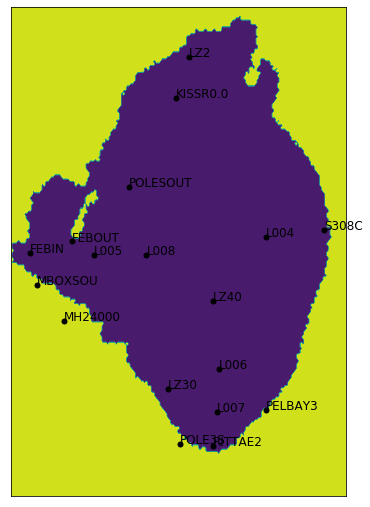

In [8]:
path = r"/Users/quachhungvietnam/Desktop/Capstone/Sentinel_3_Data/S3_LO/S3B_OL_1_EFR____20190205T153448_20190205T153748_20190206T193112_0179_021_339_2520_LN1_O_NT_002.l2.nc"
data = netCDF4.Dataset(path)
plt.figure(figsize=(6,9))
plt.contourf(data.variables["LAND"][:])
plt.xticks([])
plt.yticks([])

lon_array = np.array(data.variables["lon"])[0]
lat_array = np.sort([x[0] for x in np.array(data.variables["lat"])])

for station in Station_list:
    [[lat, lon]] = np.array(coordinate.loc[coordinate["Site Name"]==station, ["Lat2","Lon2"]])
    closest_lon = find_closest(lon_array, lon)
    closest_lat = find_closest(lat_array, lat)
    x, y = list(lon_array).index(closest_lon), list(lat_array).index(closest_lat)
    closest_lon = find_closest(lon_array, lon)
    closest_lat = find_closest(lat_array, lat)
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, station, fontsize=12)

## Example of signals from different wavelengths:

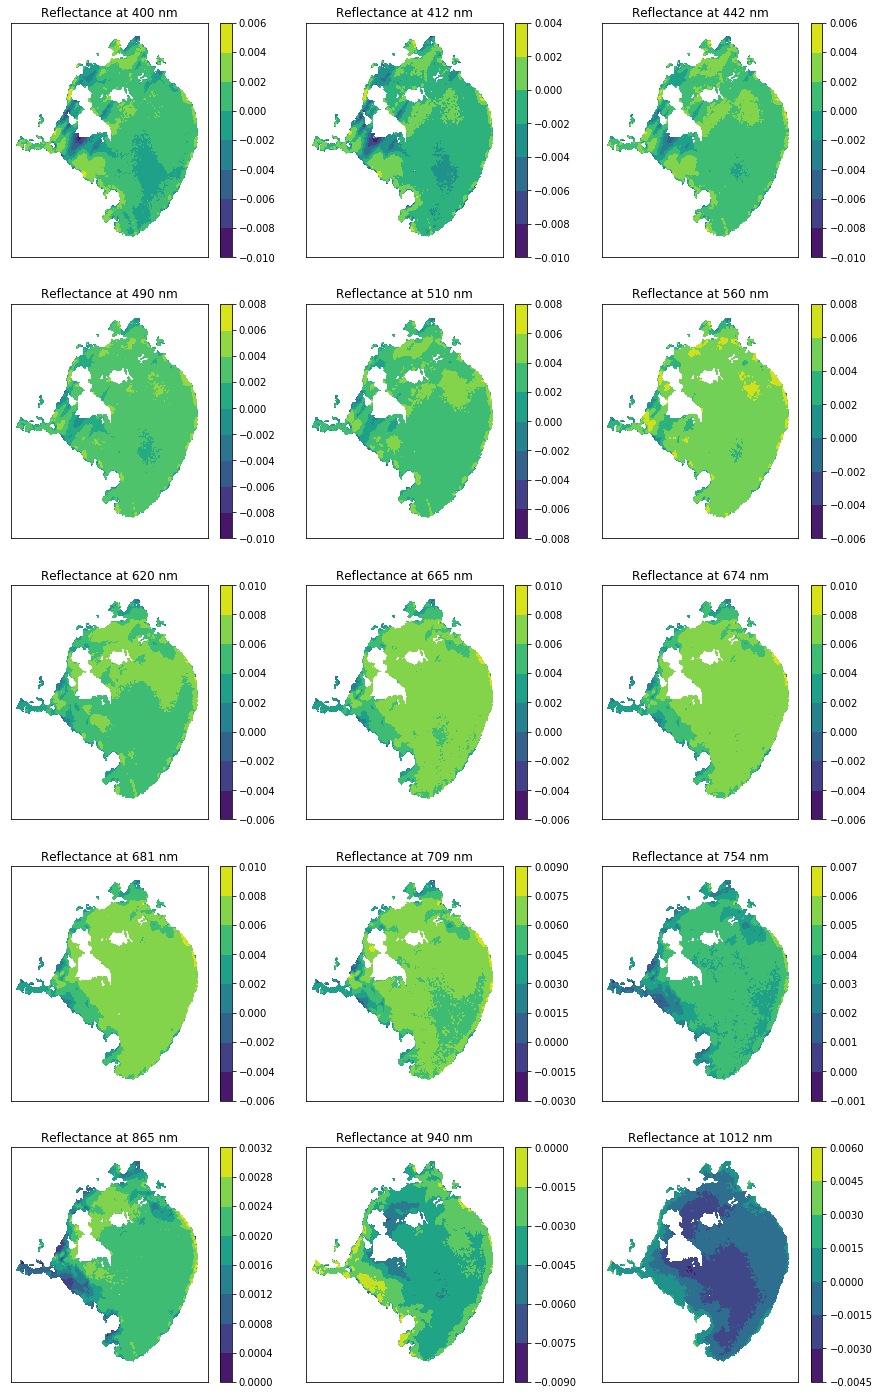

In [9]:
#land_mask and cloud_mask are used to remove the pixels of cloud and land:
land_array = np.array(data.variables["CLOUD"])
cloud_array = np.array(data.variables["LAND"])
land_mask = np.where(land_array==1, np.nan, land_array)
cloud_mask = np.where(cloud_array==1, np.nan, cloud_array)

fig = plt.figure(figsize=(5*3,5*5))
i = 0
for wavelength in wavelength_array:
    i += 1
    ax = fig.add_subplot(5, 3, i)
    sub_data = np.array(data.variables[f'Rrs_{wavelength}']) + land_mask + cloud_mask
    cs = ax.contourf(sub_data)
    fig.colorbar(cs, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Reflectance at {wavelength} nm")

## Cyanobacteria Index:

Link: https://docs.google.com/document/d/1u2b-dAuU3gP8kAXs7cQR7lHpC_tT9iweENjhLhS8TMA/edit

In [10]:
def CI_estimate(data, method):
    """
    Methods include: 
    "2BDA-PC", "3BDA-PC", "NDPCI", "2BDA-CL", "3BDA-CL", "NDCI", "Wynne"
    """
    land_array = np.array(data.variables["LAND"])
    cloud_array = np.array(data.variables["CLOUD"])
    land_mask = np.where(land_array==1, np.nan, land_array)
    cloud_mask = np.where(cloud_array==1, np.nan, cloud_array)
    
    if method == "2BDA-PC":
        Rrs709 = np.array(data.variables['Rrs_709'])
        Rrs620 = np.array(data.variables['Rrs_620'])
        return Rrs709/Rrs620
    
    if method == "3BDA-PC":
        Rrs620 = np.array(data.variables['Rrs_620'])
        Rrs665 = np.array(data.variables['Rrs_665'])
        Rrs754 = np.array(data.variables['Rrs_754'])
        return (1/Rrs620 - 1/Rrs665)*Rrs754
    
    if method == "NDPCI":
        Rrs709 = np.array(data.variables['Rrs_709'])
        Rrs620 = np.array(data.variables['Rrs_620'])
        return (Rrs709-Rrs620)/(Rrs709+Rrs620)
    
    if method == "2BDA-CL":
        Rrs709 = np.array(data.variables['Rrs_709'])
        Rrs665 = np.array(data.variables['Rrs_665'])
        return Rrs709/Rrs665
    
    if method == "3BDA-CL":
        Rrs665 = np.array(data.variables['Rrs_665'])
        Rrs709 = np.array(data.variables['Rrs_709'])
        Rrs754 = np.array(data.variables['Rrs_754'])
        return (1/Rrs665 - 1/Rrs709)*Rrs754
    
    if method == "NDCI":
        Rrs665 = np.array(data.variables['Rrs_665'])
        Rrs709 = np.array(data.variables['Rrs_709'])
        return (Rrs709-Rrs665)/(Rrs709+Rrs665)
    
    if method == "Wynne":
        Rrs681 = np.array(data.variables['Rrs_681'])
        Rrs665 = np.array(data.variables['Rrs_665'])
        Rrs709 = np.array(data.variables['Rrs_709'])
        return -(Rrs681-Rrs665-(Rrs709-Rrs665)*((681-665)/(709-665))) + land_mask + cloud_mask
    
    if method == "Scatter1":
        Rrs665 = np.array(data.variables['Rrs_665'])
        Rrs709 = np.array(data.variables['Rrs_709'])
        return Rrs709/Rrs665
    
    if method == "Scatter2":
        Rrs674 = np.array(data.variables['Rrs_674'])
        Rrs709 = np.array(data.variables['Rrs_709'])
        Rrs754 = np.array(data.variables['Rrs_754'])
        return (1/Rrs674 - 1/Rrs709)*Rrs754
    
    if method == "Scatter4":
        Rrs665 = np.array(data.variables['Rrs_665'])
        Rrs881 = np.array(data.variables['Rrs_881'])
        
    if method == "Scatter5a":
        Rrs1 = np.array(data.variables['Rrs_665'])
        Rrs2 = np.array(data.variables['Rrs_709'])
        Rrs3 = np.array(data.variables['Rrs_865'])
        return Rrs2 - Rrs1 - (Rrs3-Rrs1)*(709-665)/(865-665)+ land_mask + cloud_mask
    
    if method == "Scatter5b":
        Rrs1 = np.array(data.variables['Rrs_674'])
        Rrs2 = np.array(data.variables['Rrs_709'])
        Rrs3 = np.array(data.variables['Rrs_865'])
        return Rrs2 - Rrs1 - (Rrs3-Rrs1)*(709-764)/(865-665)+ land_mask + cloud_mask
    
    if method == "Scatter6":
        Rrs1 = np.array(data.variables['Rrs_681'])
        Rrs2 = np.array(data.variables['Rrs_709'])
        Rrs3 = np.array(data.variables['Rrs_754'])
        return Rrs2 - 1.005*(Rrs1+(Rrs3-Rrs1)*(709-681)/(754-709))+ land_mask + cloud_mask
    
    if method == "Nature":
        Rrs1 = np.array(data.variables['Rrs_665'])
        Rrs2 = np.array(data.variables['Rrs_681'])
        Rrs3 = np.array(data.variables['Rrs_709'])
        return Rrs2 - Rrs1 + (Rrs1-Rrs2)*(681-665)/(709-665)+ land_mask + cloud_mask
    
    if method == "Me":
        Rrs1 = np.array(data.variables['Rrs_620'])
        Rrs2 = np.array(data.variables['Rrs_681'])
        Rrs3 = np.array(data.variables['Rrs_709'])
        return Rrs2 - Rrs1 + (Rrs1-Rrs2)*(681-620)/(709-620)+ land_mask + cloud_mask


In [11]:
methods = ["2BDA-PC", "3BDA-PC", "NDPCI", "2BDA-CL", "3BDA-CL", "NDCI", 
           "Wynne", "Scatter1", "Scatter2", "Scatter5a","Scatter5b", "Scatter6",
          "Nature", "Me"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in subtract
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_

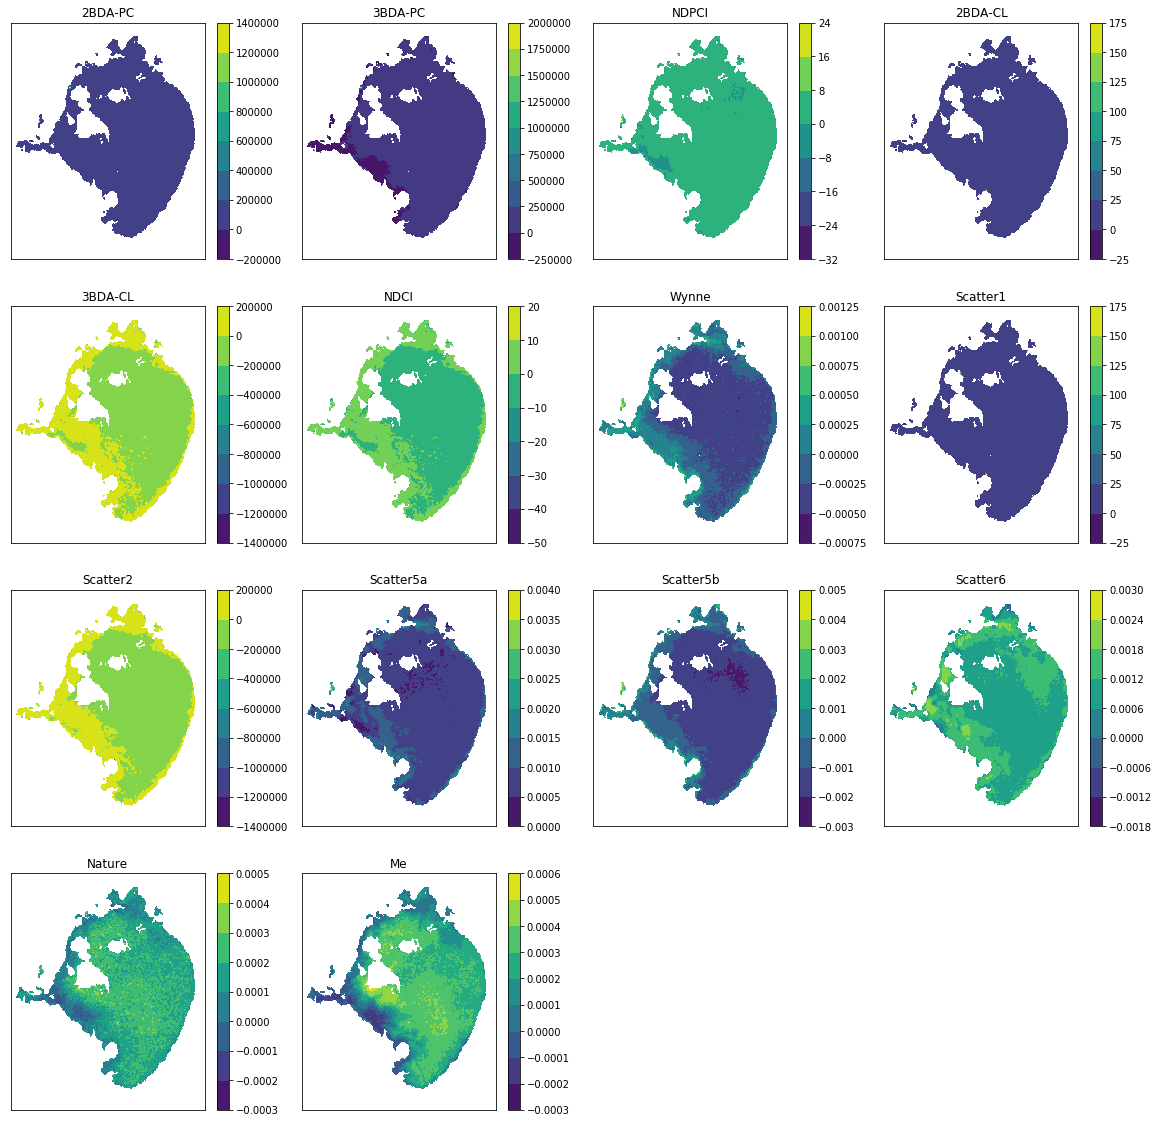

In [12]:
fig = plt.figure(figsize=(5*4,5*int(np.ceil(len(methods)/4))))
i = 0
for method in methods:
    CI_data = CI_estimate(data, method=method)
    i += 1
    ax = fig.add_subplot(int(np.ceil(len(methods)/4)),4, i)
    ax.contourf(CI_data)
    cs = ax.contourf(CI_data)
    fig.colorbar(cs, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(method)

## Full procedure:

In [13]:
def full_procedure(file):
    global coordiate, Station_list, methods
    path = f"/Users/quachhungvietnam/Desktop/Capstone/Sentinel_3_Data/S3_LO/{file}"
    data = netCDF4.Dataset(path)
    lon_array = np.array(data.variables["lon"])[0]
    lat_array = np.sort([x[0] for x in np.array(data.variables["lat"])])
    
    result = {method:{} for method in methods}
    #Transfer wavelength to cyanobacteria index:
    for method in methods:
        CI_data = CI_estimate(data, method)
        for station in Station_list:
            [[lat, lon]] = np.array(coordinate.loc[coordinate["Site Name"]==station, ["Lat2","Lon2"]])
            closest_lon = find_closest(lon_array, lon)
            closest_lat = find_closest(lat_array, lat)
            x, y = list(lon_array).index(closest_lon), list(lat_array).index(closest_lat)
            result[method][station] = np.array(CI_data)[y,x]
            
    data.close()
    return result

In [14]:
RS_result = dict()
for filename in os.listdir(f'/Users/quachhungvietnam/Desktop/Capstone/Sentinel_3_Data/S3_LO/'):
    if "S3B" in filename:
        date = filename[16:24]
        hour = filename[25:31]
        RS_result[date] = full_procedure(filename)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in subtract
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_

In [15]:
insitu_data = pd.read_csv("In_Situ/In_Situ_ChlA.csv")
insitu_data = insitu_data[["Date", "Station", "In Situ ChlA"]]
insitu_data["Date"] = list(map(lambda date: datetime.strptime(date, '%Y-%m-%d'),
                               insitu_data["Date"]))
insitu_data

,Date,Station,In Situ ChlA
0,2010-10-20,POLESOUT,6.550
1,2010-12-15,POLESOUT,7.700
2,2011-01-04,POLESOUT,20.250
3,2011-02-14,POLESOUT,13.800
4,2011-03-08,POLESOUT,15.700
...,...,...,...
2176,2020-04-08,LZ30,7.130
2177,2020-05-06,LZ30,30.500
2178,2020-05-06,LZ30,0.016
2179,2020-05-21,LZ30,11.500


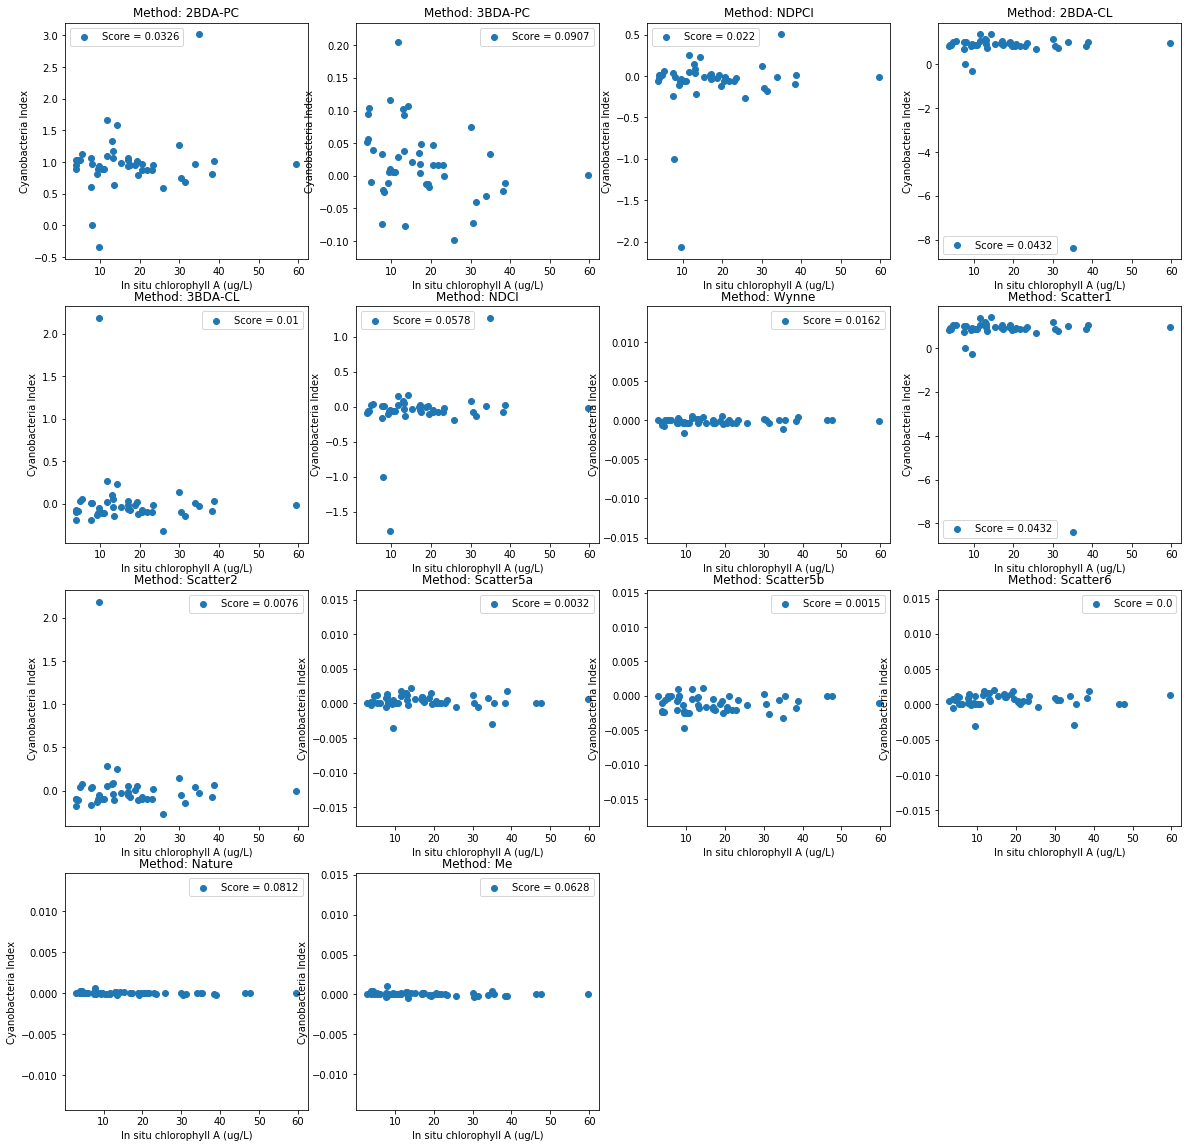

In [16]:
fig = plt.figure(figsize=(5*4,5*int(np.ceil(len(methods)/4))))
i = 0
for method in methods:
    i += 1
    date_array = []
    station_array =[]
    CI_array = []

    for date in RS_result.keys():
        for station in Station_list:
            date_array.append(date)
            station_array.append(station)
            CI_array.append(RS_result[date][method][station])
    
    RS_data = pd.DataFrame({"Date": date_array,
                            "Station": station_array,
                            "CI": CI_array})
    RS_data["Date"] = list(map(lambda date: datetime.strptime(date, '%Y%m%d'),
                                RS_data["Date"]))
    
    #Match the remote sensing data with the in situ data: 
    merged_data = pd.merge(insitu_data, RS_data, on=["Date", "Station"], how='left')
    merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()
    
    x = np.array(merged_data["In Situ ChlA"]).reshape(-1, 1)
    y = merged_data["CI"]
    #ln = linregress(x,y)
    #correlation_matrix = np.corrcoef(x, y)
    #correlation_xy = correlation_matrix[0,1]
    #r_squared = correlation_xy**2
    ln = LinearRegression().fit(x,y)
    
    ax = fig.add_subplot(int(np.ceil(len(methods)/4)),4,i)
    ax.scatter(x, y, label=f"Score = {round(ln.score(x,y),4)}")
    ax.set_xlabel("In situ chlorophyll A (ug/L)")
    ax.set_ylabel("Cyanobacteria Index")
    ax.set_title(f"Method: {method}")
    ax.legend()

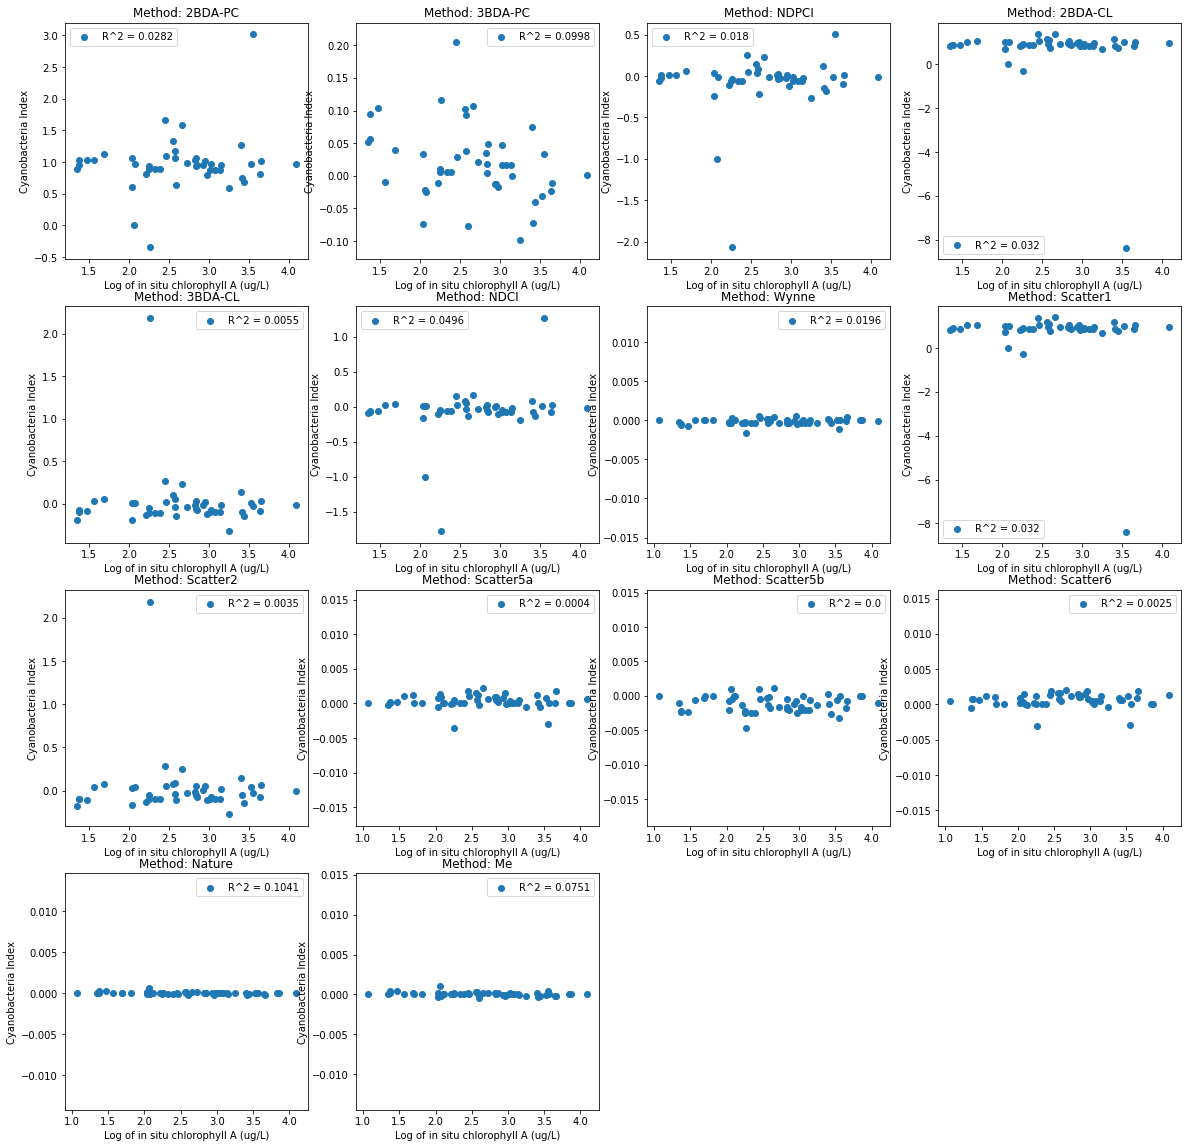

In [17]:
fig = plt.figure(figsize=(5*4,5*int(np.ceil(len(methods)/4))))
i = 0
for method in methods:
    i += 1
    date_array = []
    station_array =[]
    CI_array = []

    for date in RS_result.keys():
        for station in Station_list:
            date_array.append(date)
            station_array.append(station)
            CI_array.append(RS_result[date][method][station])
    
    RS_data = pd.DataFrame({"Date": date_array,
                            "Station": station_array,
                            "CI": CI_array})
    RS_data["Date"] = list(map(lambda date: datetime.strptime(date, '%Y%m%d'),
                                RS_data["Date"]))
    
    #Match the remote sensing data with the in situ data: 
    merged_data = pd.merge(insitu_data, RS_data, on=["Date", "Station"], how='left')
    merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()
    
    x = np.log(np.array(merged_data["In Situ ChlA"]).reshape(-1, 1))
    y = merged_data["CI"]
    ln = LinearRegression().fit(x,y)
    
    ax = fig.add_subplot(int(np.ceil(len(methods)/4)),4,i)
    ax.scatter(x, y, label=f"R^2 = {round(ln.score(x,y),4)}")
    ax.set_xlabel("Log of in situ chlorophyll A (ug/L)")
    ax.set_ylabel("Cyanobacteria Index")
    ax.set_title(f"Method: {method}")
    ax.legend()

In [18]:
def CI_proxy(data, band1, band2):
    """
    Use the ratio of band1 vs band2 to indicate the cyanobacteria index
    """
    Rrs1 = np.array(data.variables[f'Rrs_{band1}'])
    Rrs2 = np.array(data.variables[f'Rrs_{band2}'])
    return Rrs1/Rrs2

In [21]:
def full_procedure_2(band1, band2):
    global coordiate, Station_list, all_sentinel_files
    #CI index dictionary format: {[date, station]:CI}}
    result = dict()
    folder = "/Users/quachhungvietnam/Desktop/Capstone/Sentinel_3_Data/S3_LO/"
    
    for [date,data,lon_array,lat_array] in all_sentinel_files:
        CI_data = CI_proxy(data, band1, band2)
        for station in Station_list:
            [[lat, lon]] = np.array(coordinate.loc[coordinate["Site Name"]==station, ["Lat2","Lon2"]])
            closest_lon = find_closest(lon_array, lon)
            closest_lat = find_closest(lat_array, lat)
            x, y = list(lon_array).index(closest_lon), list(lat_array).index(closest_lat)
            result[(date,station)] = np.array(CI_data)[y,x]
    return result

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


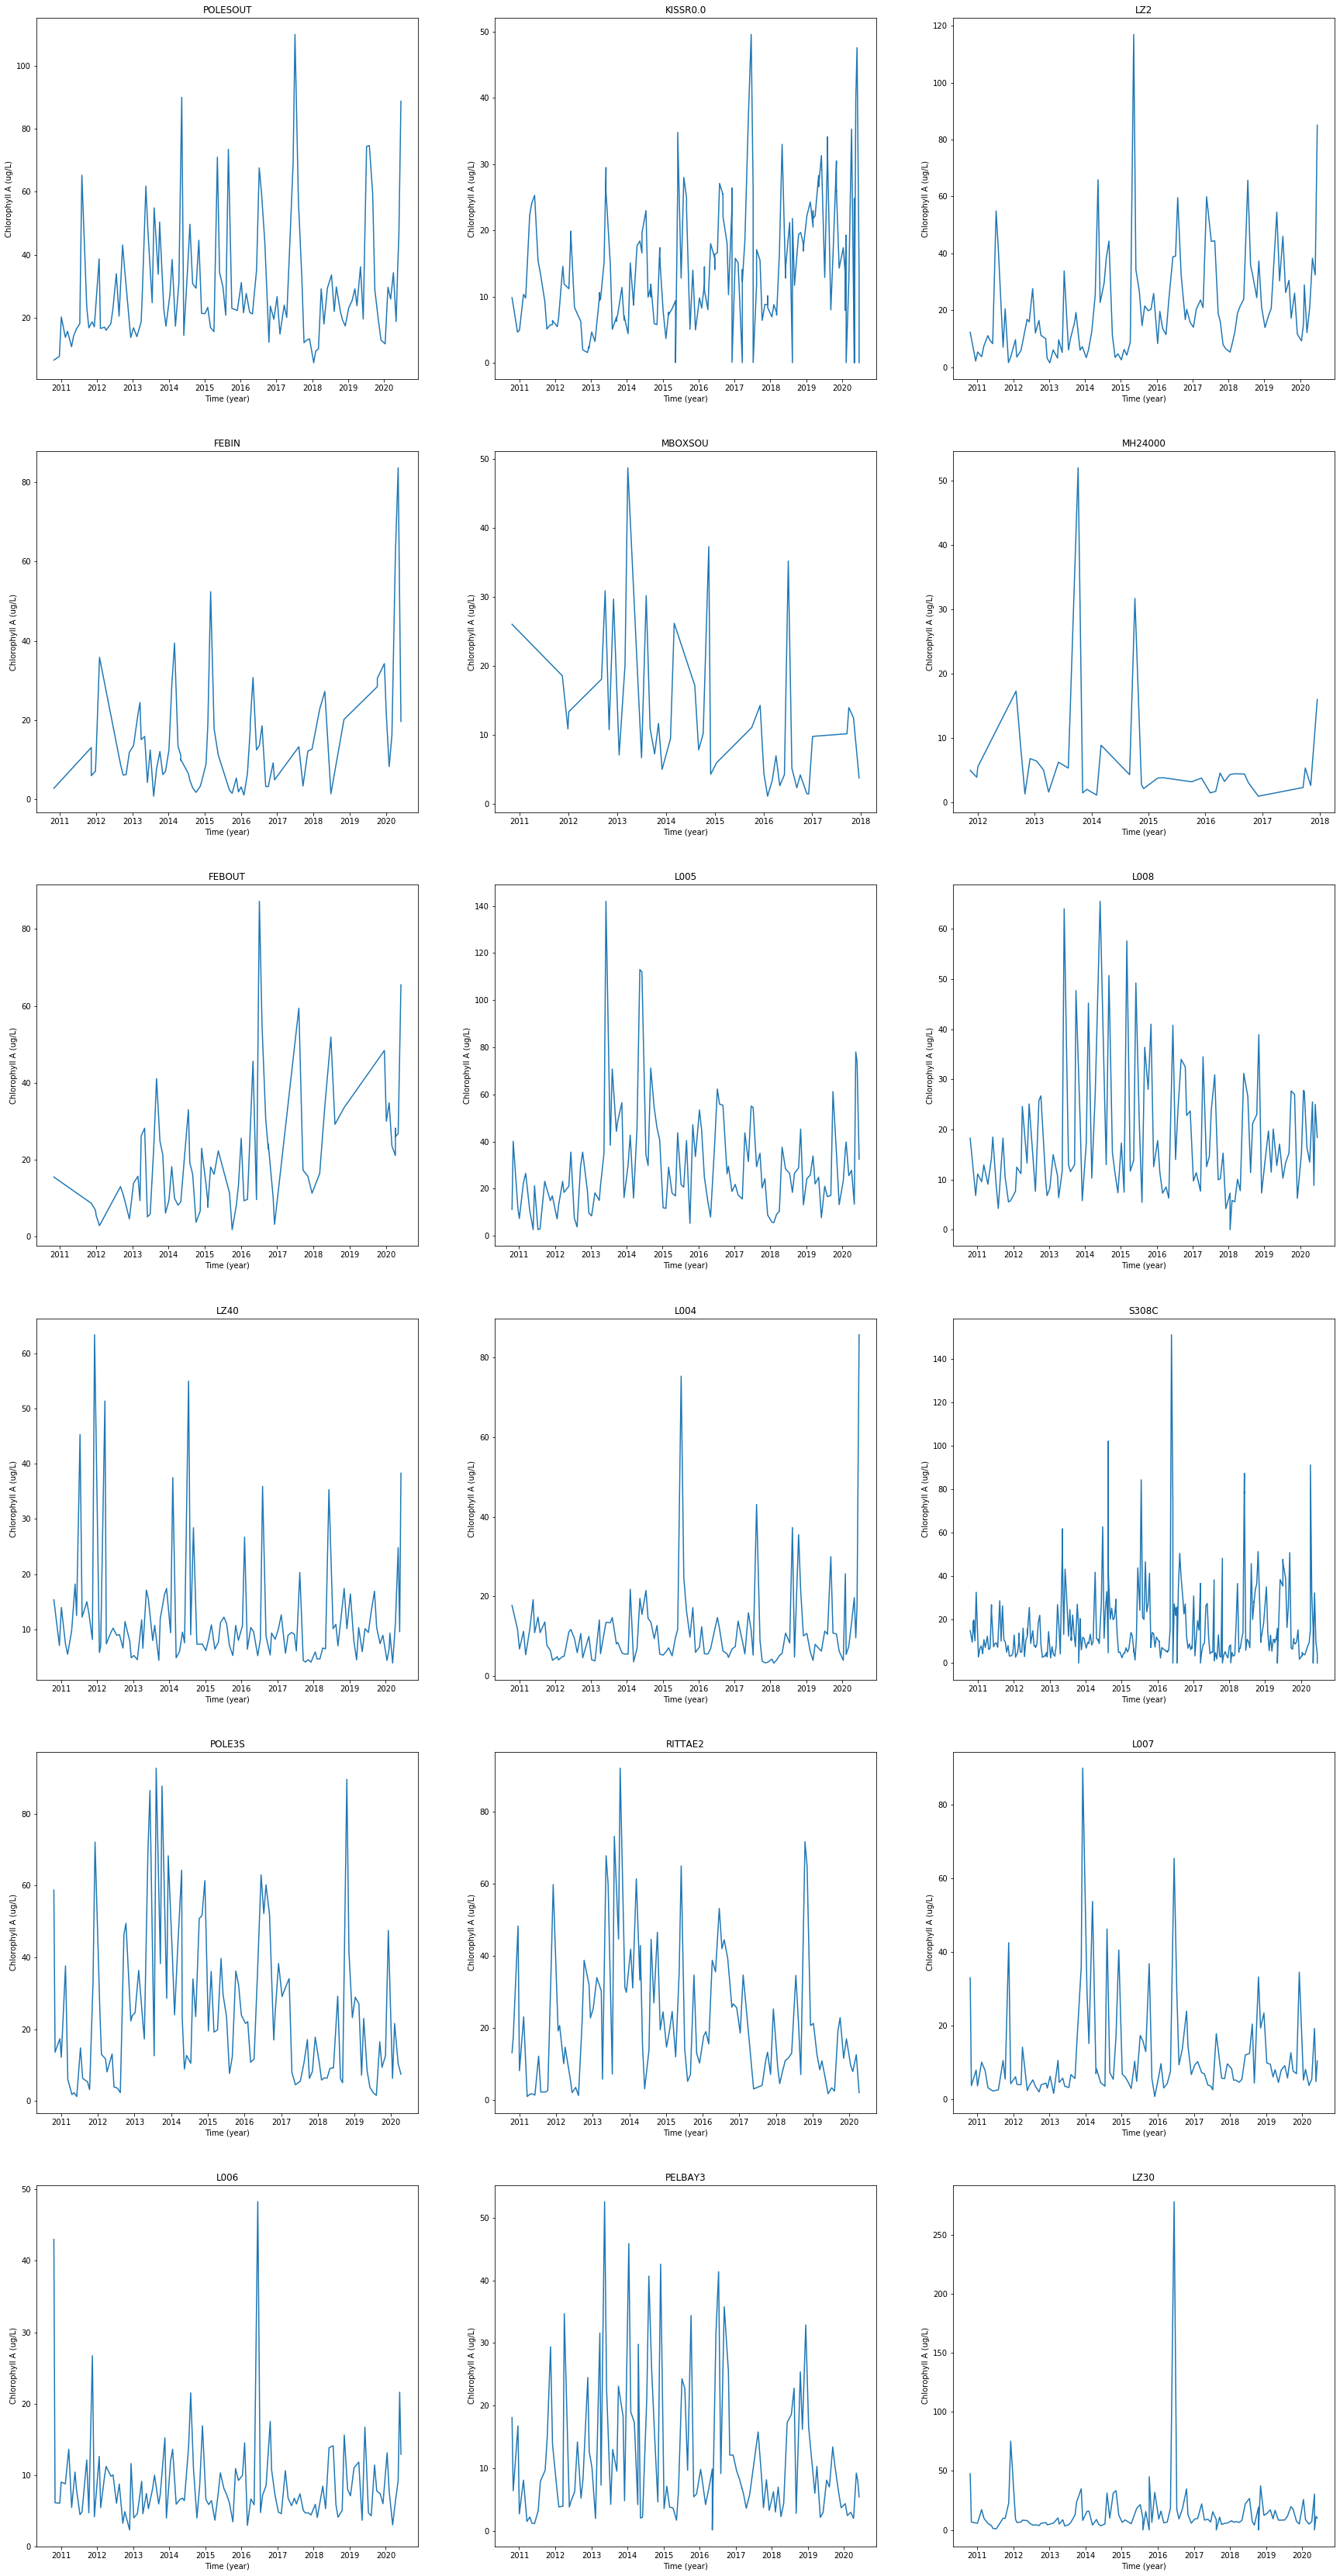

In [22]:
ncols = 3
nrows = len(Station_list)//3

plt.figure(figsize=(ncols*10, nrows*10))
i = 0
for station in Station_list:
    i += 1
    sub_data = insitu_data.loc[insitu_data["Station"]==station,:]
    plt.subplot(nrows, ncols, i)
    plt.plot(sub_data["Date"], sub_data["In Situ ChlA"])
    plt.xlabel("Time (year)")
    plt.ylabel("Chlorophyll A (ug/L)")
    plt.title(station)

In [23]:
def find_xy_index(station, lat_array, lon_array):
    global coordinate
    [[lat, lon]] = np.array(coordinate.loc[coordinate["Site Name"]==station, ["Lat2","Lon2"]])
    closest_lon = find_closest(lon_array, lon)
    closest_lat = find_closest(lat_array, lat)
    x, y = list(lon_array).index(closest_lon), list(lat_array).index(closest_lat)
    return x, y

In [24]:
def request_data(file):
    """
    Return date, data, lattitude list, longitude list from a given file name
    """
    folder = "/Users/quachhungvietnam/Desktop/Capstone/Sentinel_3_Data/S3_LO/"
    path = f"{folder}{file}"
    data = netCDF4.Dataset(path)
    date = file[16:24]
    lon_array = np.array(data.variables["lon"])[0]
    lat_array = np.sort([x[0] for x in np.array(data.variables["lat"])])
    return date, data, lon_array, lat_array

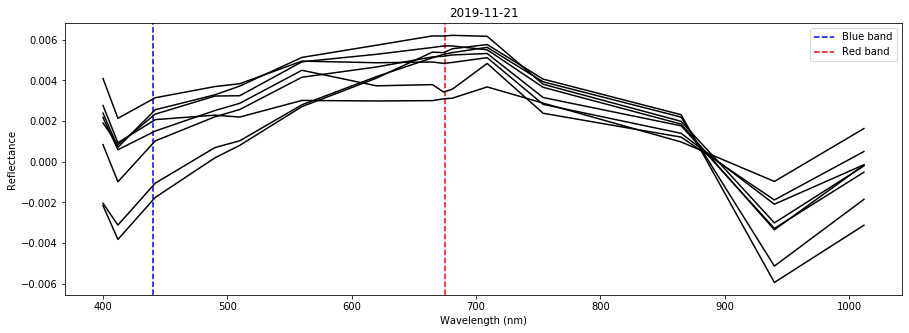

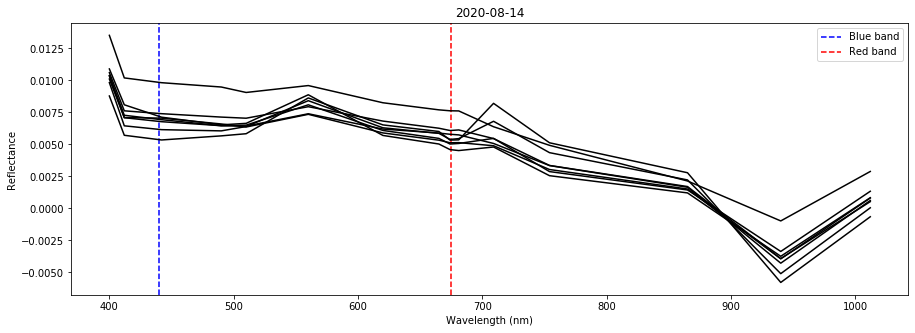

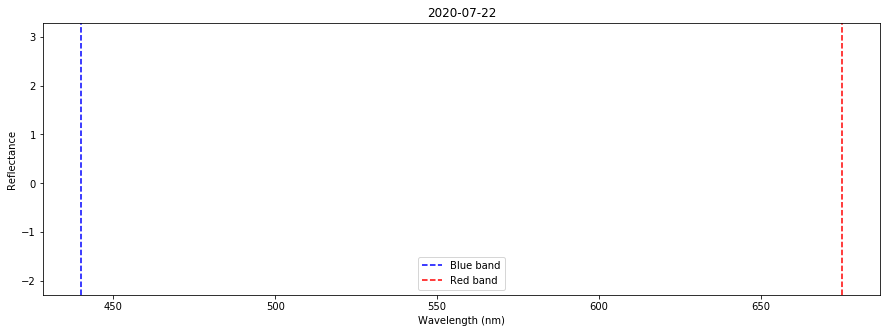

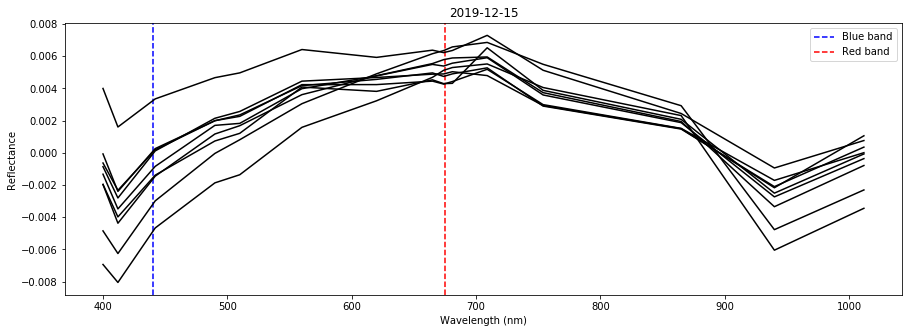

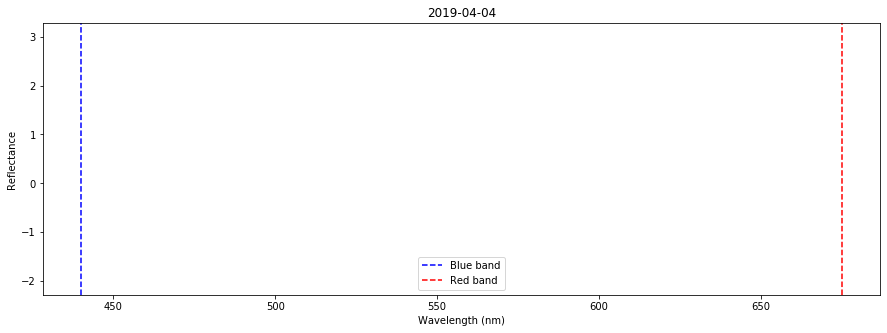

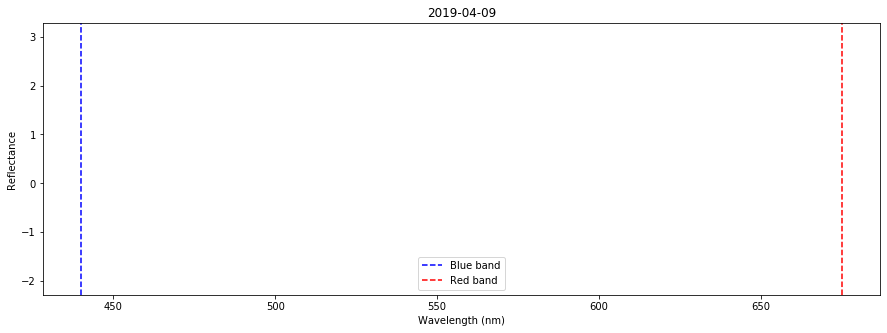

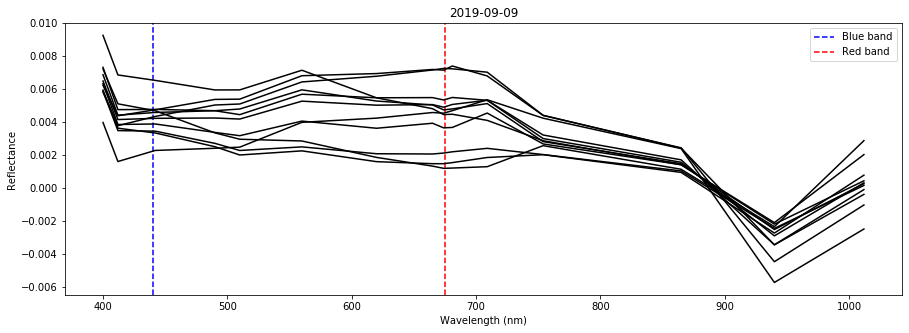

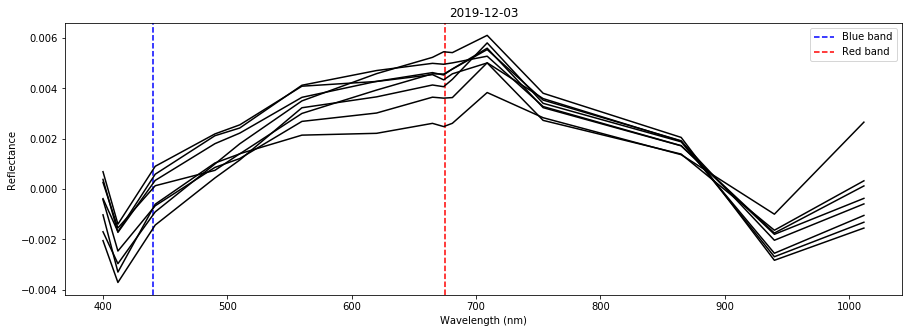

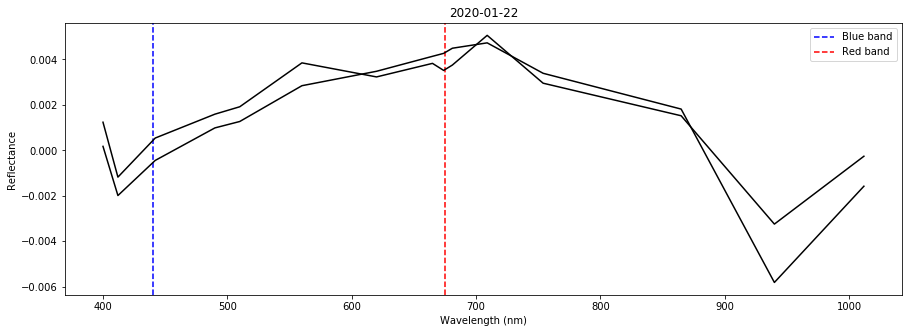

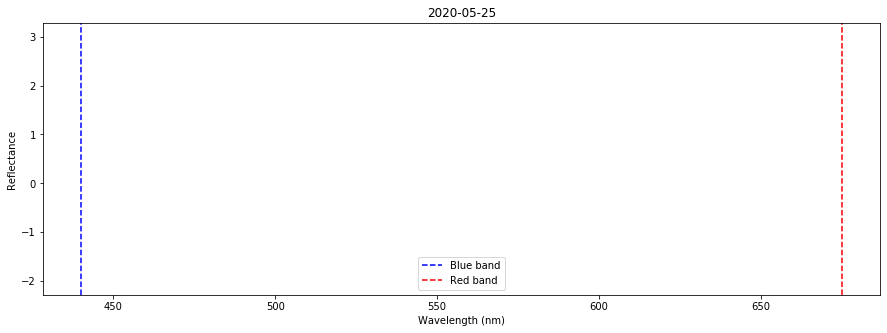

In [25]:
count = 0
for file in files:
    if "S3B" in file and count < 10:
        count += 1
        date, data, lon_array, lat_array = request_data(file)
        land_array = np.array(data.variables["LAND"])
        cloud_array = np.array(data.variables["CLOUD"])
        land_mask = np.where(land_array==1, np.nan, land_array)
        cloud_mask = np.where(cloud_array==1, np.nan, cloud_array)
        
        plt.figure(figsize=(15,5))
        plt.axvline(x=440, color="blue", label="Blue band", linestyle="--")
        plt.axvline(x=675, color="red", label="Red band", linestyle="--")
        
        for station in Station_list:
            
            x, y = find_xy_index(station, lat_array, lon_array)
            Rrs_array = []
            for wavelength in wavelength_array:
                Rrs_array.append((np.array(data.variables[f'Rrs_{wavelength}'])+land_mask+cloud_mask)[y,x])
                
            if Rrs_array != [0 for i in Rrs_array]:     
                plt.plot(wavelength_array, Rrs_array, color="black")
            
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title(f"{date[:4]}-{date[4:6]}-{date[6:]}")
        plt.legend()
        plt.show()
        data.close()

In [26]:
merged_data = pd.read_csv("RS_and_insitu.csv")

## BEFOR SMOOTHING:

### Scattering 1

In [27]:
#Look for optimal band:
two_band_result = dict()
for band1 in wavelength_array:
    for band2 in wavelength_array:
        if band1 != band2:
            merged_data["CI"] = merged_data[str(band1)]/merged_data[str(band2)]
            two_band_result[(band1, band2)] = np.array(merged_data[["CI", 'In Situ ChlA']].corr())[0,1]
            
df = pd.DataFrame({"Band1": [x[0] for x in two_band_result.keys()],
             "Band2": [x[1] for x in two_band_result.keys()],
             "Pearson R": [x for x in two_band_result.values()]}).sort_values("Pearson R").reset_index(drop=True)
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

   Band1  Band2  Pearson R
0    560    940  -0.406223


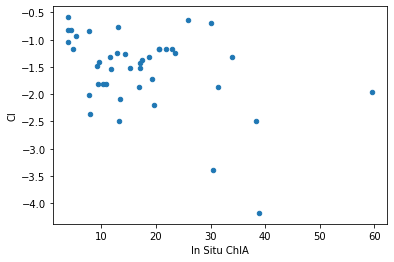

In [28]:
band1 = 560
band2 = 940
merged_data["CI"] = merged_data[str(band1)]/merged_data[str(band2)]
merged_data.plot(x='In Situ ChlA', y='CI', kind='scatter')

### Scattering 2:

In [29]:
two_band_result = dict()
for band1 in wavelength_array:
    for band2 in wavelength_array:
        if band1 != band2:
            merged_data["CI"] = (merged_data[str(band2)]-merged_data[str(band1)])/(merged_data[str(band2)]+merged_data[str(band1)])
            two_band_result[(band1, band2)] = np.array(merged_data[["CI", 'In Situ ChlA']].corr())[0,1]
            
df = pd.DataFrame({"Band1": [x[0] for x in two_band_result.keys()],
             "Band2": [x[1] for x in two_band_result.keys()],
             "Pearson R": [x for x in two_band_result.values()]}).sort_values("Pearson R").reset_index(drop=True)
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

     Band1  Band2  Pearson R
0      510    754  -0.373772
209    754    510   0.373772


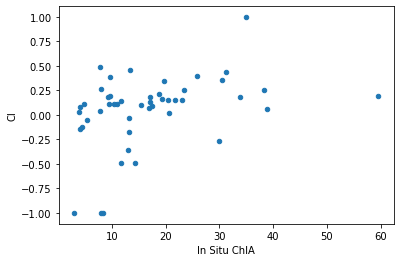

In [30]:
band1 = 754
band2 = 510
merged_data["CI"] = (merged_data[str(band2)]-merged_data[str(band1)])/(merged_data[str(band2)]+merged_data[str(band1)])
merged_data.plot(x='In Situ ChlA', y='CI', kind='scatter')

### Scattering 3

In [31]:
three_band_result = {}
for band1 in wavelength_array:
    for band2 in wavelength_array:
        for band3 in wavelength_array:
            if band3 != band1 and band3 != band2 and band1 != band2:
                merged_data["CI"] = (1/merged_data[str(band1)] - 1/merged_data[str(band2)])*merged_data[str(band3)]
                three_band_result[(band1, band2, band3)] = np.array(merged_data[["CI", 'In Situ ChlA']].corr())[0,1]
                
df = pd.DataFrame({"Band1": [x[0] for x in three_band_result.keys()],
             "Band2": [x[1] for x in three_band_result.keys()],
             "Band3": [x[2] for x in three_band_result.keys()],
             "Pearson R": [x for x in three_band_result.values()]}).sort_values("Pearson R")
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

      Band1  Band2  Band3  Pearson R
2515    940    754    620  -0.427063
2164    754    940    620   0.427063


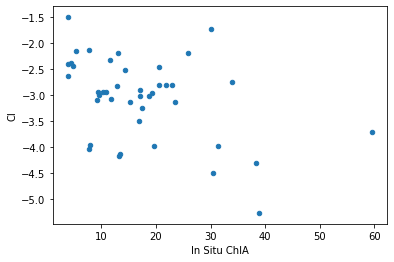

In [32]:
band1, band2, band3 = 940, 754, 620
merged_data["CI"] = (1/merged_data[str(band1)] - 1/merged_data[str(band2)])*merged_data[str(band3)]
merged_data.plot(x='In Situ ChlA', y='CI', kind='scatter')

### Fluorescence:

In [33]:
three_band_result_2 = {}
for band1 in wavelength_array:
    for band2 in wavelength_array:
        for band3 in wavelength_array:
            if band2 > band1 and band2 < band3:
                merged_data["CI"] = merged_data[str(band2)] - merged_data[str(band1)] + (merged_data[str(band1)]-merged_data[str(band2)])*(band2-band1)/(band3-band1)
                three_band_result_2[(band1, band2, band3)] = np.array(merged_data[["CI", 'In Situ ChlA']].corr())[0,1]
                
df = pd.DataFrame({"Band1": [x[0] for x in three_band_result_2.keys()],
             "Band2": [x[1] for x in three_band_result_2.keys()],
             "Band3": [x[2] for x in three_band_result_2.keys()],
             "Pearson R": [x for x in three_band_result_2.values()]}).sort_values("Pearson R")
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

     Band1  Band2  Band3  Pearson R
405    665    681    709  -0.135237


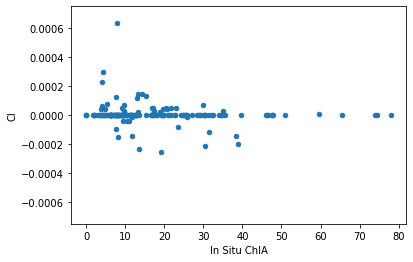

In [34]:
band1, band2, band3 = 665, 681, 709
merged_data["CI"] = merged_data[str(band2)] - merged_data[str(band1)] + (merged_data[str(band1)]-merged_data[str(band2)])*(band2-band1)/(band3-band1)
merged_data.plot(x='In Situ ChlA', y='CI', kind='scatter', ylim=(-0.00075,0.00075))

In [35]:
#Choose data that exclude outliers for in situ chlA:
merged_data_2 = pd.read_csv("RS_and_insitu.csv")
merged_data_2 = merged_data_2.loc[merged_data_2['In Situ ChlA']<=40,:]

## SMOOTHING DATA:

In [36]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3734471/

#First order smooth:
for current_band, next_band in zip(wavelength_array[:-1], wavelength_array[1:]):
    merged_data_2[f"first {current_band}"] = (merged_data_2[str(next_band)]-merged_data_2[str(current_band)])/(next_band-current_band)
    merged_data_2[f"first{current_band}"] = (merged_data_2[str(next_band)]-merged_data_2[str(current_band)])/(next_band-current_band)
#Second order smooth:    
for current_band, next_band in zip(wavelength_array[:-2], wavelength_array[1:-1]):
    merged_data_2[f"second {current_band}"] = (merged_data_2[f"first {next_band}"]-merged_data_2[f"first {current_band}"])/(next_band-current_band)
    merged_data_2[f"second{current_band}"] = (merged_data_2[f"first {next_band}"]-merged_data_2[f"first {current_band}"])/(next_band-current_band)

### Show the effect of smoothing data:

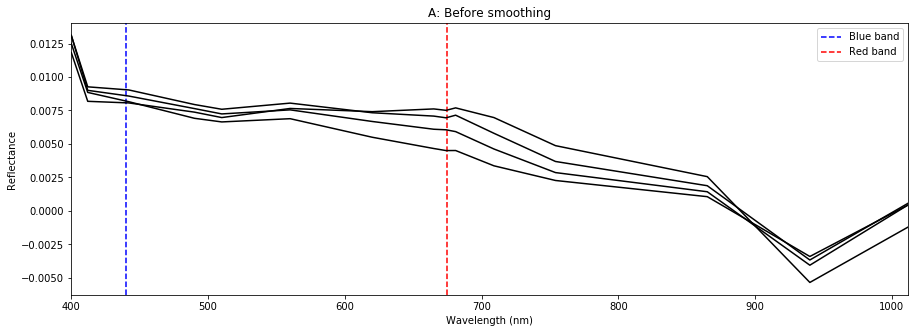

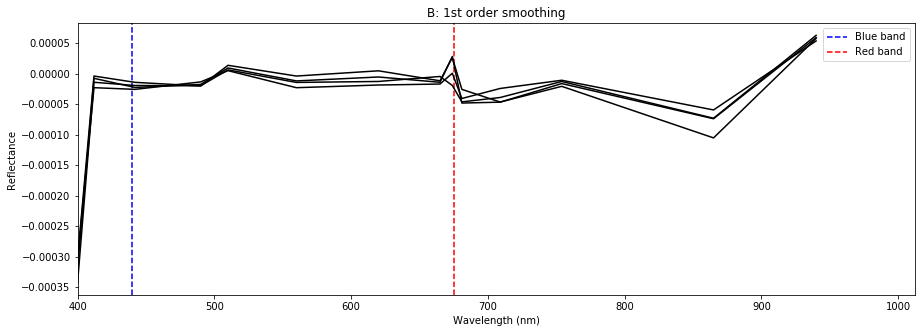

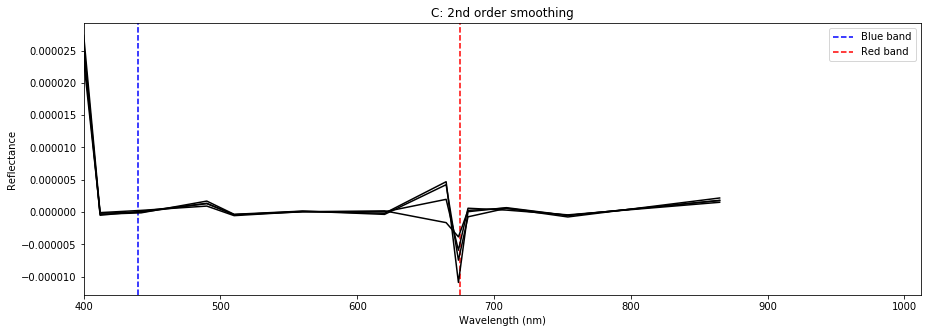

In [37]:
date = "2019-06-05"
data = merged_data_2.loc[merged_data_2["Date"]==date,:]
#Before smoothing:
plt.figure(figsize=(15,5))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("A: Before smoothing")
plt.axvline(x=440, color="blue", label="Blue band", linestyle="--")
plt.axvline(x=675, color="red", label="Red band", linestyle="--")
plt.legend()
plt.xlim(min(wavelength_array), max(wavelength_array))
for i in list(data.index):
    station_data = []
    for wavelength in wavelength_array:
        station_data.append(data[str(wavelength)][i])
    if station_data != [0 for x in station_data]:
        plt.plot(wavelength_array, station_data, color="black")
    
#After smoothing:
##1st order smoothing:
plt.figure(figsize=(15,5))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("B: 1st order smoothing")
plt.axvline(x=440, color="blue", label="Blue band", linestyle="--")
plt.axvline(x=675, color="red", label="Red band", linestyle="--")
plt.legend()
plt.xlim(min(wavelength_array), max(wavelength_array))
for i in list(data.index):
    station_data = []
    for wavelength in wavelength_array[:-1]:
        station_data.append(data[f"first {wavelength}"][i])
    if station_data != [0 for x in station_data]:
        plt.plot(wavelength_array[:-1], station_data, color="black")
        
##2nd order smoothing:
plt.figure(figsize=(15,5))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("C: 2nd order smoothing")
plt.axvline(x=440, color="blue", label="Blue band", linestyle="--")
plt.axvline(x=675, color="red", label="Red band", linestyle="--")
plt.legend()
plt.xlim(min(wavelength_array), max(wavelength_array))
for i in list(data.index):
    station_data = []
    for wavelength in wavelength_array[:-2]:
        station_data.append(data[f"second {wavelength}"][i])
    if station_data != [0 for x in station_data]:
        plt.plot(wavelength_array[:-2], station_data, color="black")

### Use 1st order smoothing data:

In [38]:
def cal_CI(merged_data_2=merged_data_2, smooth='first', method='Scattering 1', band1=0, band2=0, band3=None):
    band1_val = merged_data_2[f"{smooth}{band1}"]
    band2_val = merged_data_2[f"{smooth}{band2}"]
    if band3 != None:
        band3_val = merged_data_2[f"{smooth}{band3}"]
    
    if method=='Scattering 1':
        merged_data_2["CI"] = band1_val/band2_val
    if method=='Scattering 2':
        merged_data["CI"] = (band2_val-band1_val)/(band2_val+band1_val)
    if method=='Scattering 3':
        merged_data["CI"] = (1/band1_val - 1/band2_val)*band3_val
    if method=='Fluorescence':
        merged_data_2["CI"] = band2_val - band1_val + (band1_val-band2_val)*(band2-band1)/(band3-band1)
    return merged_data_2

In [39]:
#Scattering 1
two_band_result = dict()
for band1 in wavelength_array[:-1]:
    for band2 in wavelength_array[:-1]:
        if band1 != band2:
            merged_data_2["CI"] = merged_data_2[f"first {band1}"]/merged_data_2[f"first {band2}"]
            two_band_result[(band1, band2)] = np.array(merged_data_2[["CI", 'In Situ ChlA']].corr())[0,1]
            
df = pd.DataFrame({"Band1": [x[0] for x in two_band_result.keys()],
                             "Band2": [x[1] for x in two_band_result.keys()],
                             "Pearson R": [x for x in two_band_result.values()]}).sort_values("Pearson R")

optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

     Band1  Band2  Pearson R
141    709    865  -0.336997


In [40]:
#Scattering 2:
two_band_result = dict()
for band1 in wavelength_array[:-1]:
    for band2 in wavelength_array[:-1]:
        if band1 != band2:
            band1_val = merged_data_2[f"first {band1}"]
            band2_val = merged_data_2[f"first {band2}"]
            merged_data["CI"] = (band2_val-band1_val)/(band2_val+band1_val)
            two_band_result[(band1, band2)] = np.array(merged_data[["CI", 'In Situ ChlA']].corr())[0,1]
            
df = pd.DataFrame({"Band1": [x[0] for x in two_band_result.keys()],
             "Band2": [x[1] for x in two_band_result.keys()],
             "Pearson R": [x for x in two_band_result.values()]}).sort_values("Pearson R").reset_index(drop=True)
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

     Band1  Band2  Pearson R
0      442    620  -0.381145
181    620    442   0.381145


In [41]:
#Scattering 3:
three_band_result = {}
for band1 in wavelength_array[:-1]:
    for band2 in wavelength_array[:-1]:
        for band3 in wavelength_array[:-1]:
            if band3 != band1 and band3 != band2 and band1 != band2:
                band1_val = merged_data_2[f"first {band1}"]
                band2_val = merged_data_2[f"first {band2}"]
                band3_val = merged_data_2[f"first {band3}"]
                merged_data_2["CI"] = (1/band1_val - 1/band2_val)*band3_val
                three_band_result[(band1, band2, band3)] = np.array(merged_data_2[["CI", 'In Situ ChlA']].corr())[0,1]
                
df = pd.DataFrame({"Band1": [x[0] for x in three_band_result.keys()],
             "Band2": [x[1] for x in three_band_result.keys()],
             "Band3": [x[2] for x in three_band_result.keys()],
             "Pearson R": [x for x in three_band_result.values()]}).sort_values("Pearson R")
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

      Band1  Band2  Band3  Pearson R
562     490    674    865  -0.374372
1294    674    490    865   0.374372


In [42]:
#Fluorescence: 
three_band_result_2 = {}
for band1 in wavelength_array[:-1]:
    for band2 in wavelength_array[:-1]:
        for band3 in wavelength_array[:-1]:
            if band2 > band1 and band2 < band3:
                band1_val = merged_data_2[f"first {band1}"]
                band2_val = merged_data_2[f"first {band2}"]
                band3_val = merged_data_2[f"first {band3}"]
                merged_data_2["CI"] = band2_val - band1_val + (band1_val-band2_val)*(band2-band1)/(band3-band1)
                three_band_result_2[(band1, band2, band3)] = np.array(merged_data_2[["CI", 'In Situ ChlA']].corr())[0,1]
                
df = pd.DataFrame({"Band1": [x[0] for x in three_band_result_2.keys()],
             "Band2": [x[1] for x in three_band_result_2.keys()],
             "Band3": [x[2] for x in three_band_result_2.keys()],
             "Pearson R": [x for x in three_band_result_2.values()]}).sort_values("Pearson R")
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

     Band1  Band2  Band3  Pearson R
248    510    560    709  -0.220066


### Use 2nd order smoothing data:

In [43]:
#Scattering 1:
two_band_result = dict()
for band1 in wavelength_array[:-2]:
    for band2 in wavelength_array[:-2]:
        if band1 != band2:
            merged_data_2["CI"] = merged_data_2[f"second {band1}"]/merged_data_2[f"second {band2}"]
            two_band_result[(band1, band2)] = np.array(merged_data_2[["CI", 'In Situ ChlA']].corr())[0,1]
            
df = pd.DataFrame({"Band1": [x[0] for x in two_band_result.keys()],
                             "Band2": [x[1] for x in two_band_result.keys()],
                             "Pearson R": [x for x in two_band_result.values()]}).sort_values("Pearson R")

optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

    Band1  Band2  Pearson R
52    510    560   -0.41926


In [44]:
#Scattering 2:
two_band_result = dict()
for band1 in wavelength_array[:-2]:
    for band2 in wavelength_array[:-2]:
        if band1 != band2:
            band1_val = merged_data_2[f"second {band1}"]
            band2_val = merged_data_2[f"second {band2}"]
            merged_data["CI"] = (band2_val-band1_val)/(band2_val+band1_val)
            two_band_result[(band1, band2)] = np.array(merged_data[["CI", 'In Situ ChlA']].corr())[0,1]
            
df = pd.DataFrame({"Band1": [x[0] for x in two_band_result.keys()],
             "Band2": [x[1] for x in two_band_result.keys()],
             "Pearson R": [x for x in two_band_result.values()]}).sort_values("Pearson R").reset_index(drop=True)
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

     Band1  Band2  Pearson R
0      865    510  -0.362877
155    510    865   0.362877


In [45]:
#Scattering 3:
three_band_result = {}
for band1 in wavelength_array[:-2]:
    for band2 in wavelength_array[:-2]:
        for band3 in wavelength_array[:-2]:
            if band3 != band1 and band3 != band2 and band1 != band2:
                band1_val = merged_data_2[f"second {band1}"]
                band2_val = merged_data_2[f"second {band2}"]
                band3_val = merged_data_2[f"second {band3}"]
                merged_data_2["CI"] = (1/band1_val - 1/band2_val)*band3_val
                three_band_result[(band1, band2, band3)] = np.array(merged_data_2[["CI", 'In Situ ChlA']].corr())[0,1]
                
df= pd.DataFrame({"Band1": [x[0] for x in three_band_result.keys()],
             "Band2": [x[1] for x in three_band_result.keys()],
             "Band3": [x[2] for x in three_band_result.keys()],
             "Pearson R": [x for x in three_band_result.values()]}).sort_values("Pearson R")
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

     Band1  Band2  Band3  Pearson R
696    560    490    510  -0.423183
443    490    560    510   0.423183


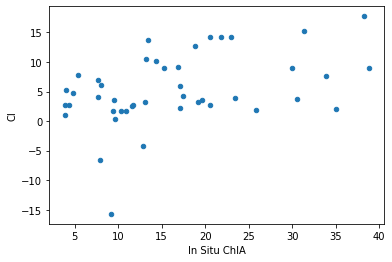

In [46]:
band1, band2, band3 = 490, 560, 510
band1_val = merged_data_2[f"second {band1}"]
band2_val = merged_data_2[f"second {band2}"]
band3_val = merged_data_2[f"second {band3}"]
merged_data_2["CI"] = (1/band1_val - 1/band2_val)*band3_val
merged_data_2.plot(x='In Situ ChlA', y='CI', kind='scatter')

In [47]:
#Fluorescence: 
three_band_result_2 = {}
for band1 in wavelength_array[:-2]:
    for band2 in wavelength_array[:-2]:
        for band3 in wavelength_array[:-2]:
            if band2 > band1 and band2 < band3:
                band1_val = merged_data_2[f"second {band1}"]
                band2_val = merged_data_2[f"second {band2}"]
                band3_val = merged_data_2[f"second {band3}"]
                merged_data_2["CI"] = band2_val - band1_val + (band1_val-band2_val)*(band2-band1)/(band3-band1)
                three_band_result_2[(band1, band2, band3)] = np.array(merged_data_2[["CI", 'In Situ ChlA']].corr())[0,1]
                
df = pd.DataFrame({"Band1": [x[0] for x in three_band_result_2.keys()],
             "Band2": [x[1] for x in three_band_result_2.keys()],
             "Band3": [x[2] for x in three_band_result_2.keys()],
             "Pearson R": [x for x in three_band_result_2.values()]}).sort_values("Pearson R")
optimal_R = np.max(np.abs(df["Pearson R"]))
print(df.loc[(df["Pearson R"]==optimal_R)|(df["Pearson R"]==-optimal_R), :])

     Band1  Band2  Band3  Pearson R
204    510    560    674   0.223111


## Calibration curve construction:

In [86]:
list_reg_model = [LinearRegression(),
                  Ridge(alpha=10),
                 RandomForestRegressor(),
                 GradientBoostingRegressor(),
                 BayesianRidge(compute_score=True)]

list_reg_name = ["Linear Regression",
                 "Ridge Regression",
                "Random Forest Regressor",
                "Gradient Boosting Regressor",
                "Bayesian Ridge"]

In [76]:
band1, band2, band3 = 490, 560, 510
band1_val = merged_data_2[f"second {band1}"]
band2_val = merged_data_2[f"second {band2}"]
band3_val = merged_data_2[f"second {band3}"]
merged_data_2["CI"] = (1/band1_val - 1/band2_val)*band3_val

data = merged_data_2[["In Situ ChlA", "CI"]].replace([np.inf, -np.inf], np.nan).dropna()
X = np.array(data['CI']).reshape(-1, 1)
y = np.array(data["In Situ ChlA"])

In [96]:
#Create a set of index for training set and testing set for 20-fold cross-validation:
n_splits=20
all_index = list(range(len(X)))
train_test_index_array = []
for _ in range(n_splits):
    train_test_index_array.append(train_test_split(all_index, test_size=0.33))

In [106]:
for reg_name, reg_model in zip(list_reg_name, list_reg_model):
    reg = reg_model.fit(X,y)
    print("Regression method: ", reg_name)
    print("R^2 score on training set:", reg.score(X,y))
    
    #r2_cv_array = []
    MAE_cv_array = []
    for train_index, test_index in LeaveOneOut().split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        reg = reg_model.fit(X_train, y_train)
        #r2_cv_array.append(reg.score(X_test,y_test))
        y_pred = reg.predict(X_test)
        MAE_cv_array.append(mean_absolute_error(y_test, y_pred))
    #print("Mean R^2 score on testing set:", np.mean(r2_cv_array))
    print("MAE on testing set:", np.mean(MAE_cv_array))
    print("--")

Regression method:  Linear Regression
R^2 score on training set: 0.17908345700355288
MAE on testing set: 7.325804274578653
--
Regression method:  Ridge Regression
R^2 score on training set: 0.1790764140073089
MAE on testing set: 7.32221098502975
--
Regression method:  Random Forest Regressor
R^2 score on training set: 0.814335052270482
MAE on testing set: 7.2742450216450205
--
Regression method:  Gradient Boosting Regressor
R^2 score on training set: 0.9787776957826139
MAE on testing set: 8.390446397111173
--
Regression method:  Bayesian Ridge
R^2 score on training set: 0.17704853737072235
MAE on testing set: 7.306512937768852
--


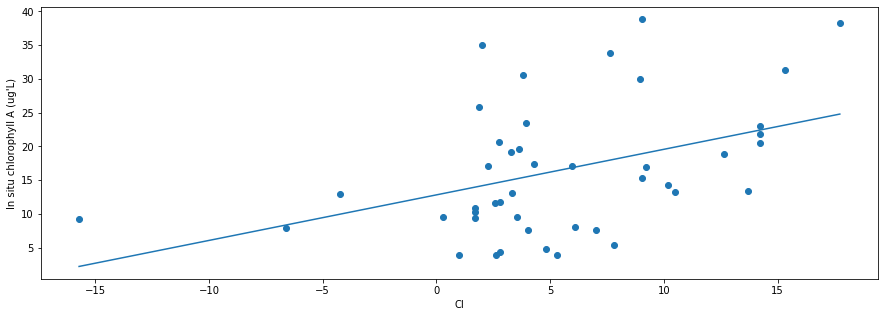

In [107]:
plt.figure(figsize=(15,5))
plt.scatter(X,y)
reg = LinearRegression().fit(X,y)
X_pred = np.linspace(min(X),max(X),100).reshape(-1,1)
y_pred = reg.predict(X_pred)
plt.plot(X_pred, y_pred)
plt.xlabel("CI")
plt.ylabel("In situ chlorophyll A (ug'L)")
plt.show()

No handles with labels found to put in legend.


R^2 score: 0.21082507095943304


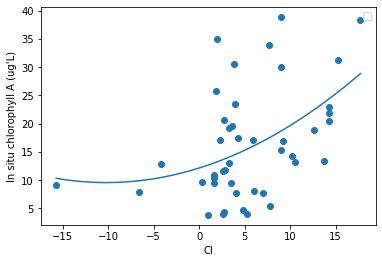

In [54]:
data = merged_data_2[["In Situ ChlA", "CI"]].replace([np.inf, -np.inf], np.nan).dropna()
X = np.array(data['CI']).reshape(-1, 1)
y = data["In Situ ChlA"]
degree = 2
X2 = PolynomialFeatures(degree).fit_transform(X)
reg = LinearRegression().fit(X2,y)

print("R^2 score:", reg.score(X2,y))
plt.scatter(X,y)
X_pred = np.linspace(min(X),max(X),100).reshape(-1,1)
X_pred_2 = PolynomialFeatures(degree).fit_transform(X_pred)
plt.plot(X_pred, reg.predict(X_pred_2),)
plt.legend()
plt.xlabel("CI")
plt.ylabel("In situ chlorophyll A (ug'L)")
plt.show()